# **Contradictory, My Dear Watson: Multi-Model Classification Write-Up**

---

## 1. Introduction

Textual Entailment (also known as Natural Language Inference, or NLI) is a core task in Natural Language Processing (NLP) that involves determining whether a given *hypothesis* can be inferred from a *premise*. Specifically, the relationship is categorized as **entailment**, **contradiction**, or **neutrality**.

In the [“Contradictory, My Dear Watson”](https://www.kaggle.com/competitions/contradictory-my-dear-watson) Kaggle competition, the challenge is to classify sentence pairs across multiple languages into one of these three classes. Our approach leverages powerful transformer-based models from the [Hugging Face](https://huggingface.co/) library. By fine-tuning several state-of-the-art multilingual models, we aim to determine which architecture best captures the nuances of cross-lingual textual entailment.

> **Notebook Outline:**  
> 1. Introduction  
> 2. Problem Description  
> 3. Model Selection  
> 4. Method / Code  
> 5. Conclusion  
> 6. References

---

## 2. Problem Description

The task at hand involves analyzing pairs of sentences, where each pair consists of:
- A **premise**: a given sentence or statement.
- A **hypothesis**: another sentence that may or may not be logically inferred from the premise.
- A **label**: indicating whether the hypothesis is in **entailment**, **contradiction**, or **neutral** relation with the premise.

This problem is inherently challenging due to its multilingual nature, with data drawn from 15 different languages. The cross-lingual aspect demands models that can robustly capture semantic relationships despite linguistic diversity. By formulating this as a three-class classification problem, we can systematically evaluate the performance of various pretrained transformer models on their ability to generalize across languages.

---

## 3. Model Selection and Tokenization Details

In our experiments, we compare four prominent multilingual transformer models:

### 1. **XLM-RoBERTa**  
XLM-RoBERTa, as introduced in [Conneau et al., 2020](https://arxiv.org/abs/1911.02116), is designed for robust cross-lingual performance.
- XLM-R is a multilingual variant of RoBERTa, trained on **100 languages** using the **CC-100 corpus**.
- Its architecture and training procedure enable it to capture nuanced semantic relationships across languages, which is critical for tasks like textual entailment.


### 2. **Multilingual BERT (mBERT)**  
Multilingual BERT, detailed in [Devlin et al., 2019](https://arxiv.org/abs/1810.04805), supports 104 languages using a shared WordPiece vocabulary.
- Trained on the **Wikipedia corpora of 104 languages**, making it highly effective for multilingual tasks.
- Retains the Next Sentence Prediction (NSP) task, which may be useful for certain textual inference problems.
- Despite being an earlier model, it remains a **strong baseline** for multilingual NLP.


### 3. **mDeBERTa**  
mDeBERTa is an extension of the DeBERTa architecture as described in [He et al., 2021](https://arxiv.org/abs/2006.03654).
- Introduces a **disentangled attention mechanism** that separately encodes content and positional embeddings, enhancing contextual learning.
- Incorporates an **enhanced mask decoder**, helping it outperform standard BERT-based models on classification tasks.
- Demonstrates strong performance on multilingual tasks due to diverse pretraining.


### 4. **mBART**  
mBART, described in [Liu et al., 2020](https://arxiv.org/abs/2001.08210), is a sequence-to-sequence model pre-trained for multilingual translation tasks.
- While originally designed for machine translation, its pretrained representations have been successfully fine-tuned for various multilingual NLP tasks, including textual entailment.
- Its encoder-decoder architecture allows for capturing rich contextual representations across languages.


> ### Model Summary
> All four models restrict inputs to a **512-token limit**, ensuring computational feasibility. However, their tokenization strategies differ slightly:
> - **XLM-RoBERTa** and **mDeBERTa** both use SentencePiece/BPE tokenization, emphasizing efficiency in subword representation.
> - **mBERT** relies on WordPiece tokenization, which tends to produce more granular subword units.
> - **mBART** also uses SentencePiece but is designed as an encoder-decoder model, offering additional flexibility in handling sequence-to-sequence tasks.
>
> In terms of overall performance for our multilingual NLI task:
> - **XLM-RoBERTa** is expected to excel due to its superior cross-lingual representations.
> - **mBERT** provides a strong baseline, though it is slightly older.
> - **mDeBERTa** benefits from improved attention mechanisms.
> - **mBART** offers the potential of leveraging sequence-to-sequence pretraining for enhanced context modeling.
>
> Further fine-tuning and hyperparameter optimization tailored to each model could yield additional improvements in classification performance.
---

## 4. Method / Code

#### Cell 1: Environment Setup

In [1]:
# !pip install transformers --quiet

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import shutil  # For copying best model's CSV
from transformers import AutoTokenizer, TFAutoModel
from tensorflow import keras

# For reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print('Setup complete!')

Setup complete!


#### Cell 2: Loading the Dataset

In [2]:
train_data = pd.read_csv(
    "https://raw.githubusercontent.com/caseym7875/DSCI-478-Kaggle/refs/heads/main/train.csv"
)
test_data = pd.read_csv(
    "https://raw.githubusercontent.com/caseym7875/DSCI-478-Kaggle/refs/heads/main/test.csv"
)

print('Train shape:', train_data.shape)
print('Test shape:', test_data.shape)
train_data.head()

# Calculate average word count for premises and hypotheses
avg_premise_length = train_data['premise'].apply(lambda x: len(x.split())).mean()
avg_hypothesis_length = train_data['hypothesis'].apply(lambda x: len(x.split())).mean()

max_premise_length = train_data['premise'].apply(lambda x: len(x.split())).max()
max_hypothesis_length = train_data['hypothesis'].apply(lambda x: len(x.split())).max()

print("\nAverage premise length (in words): {:.2f}".format(avg_premise_length))
print("Average hypothesis length (in words): {:.2f}".format(avg_hypothesis_length))

print("\nMax premise length (in words): {:.2f}".format(max_premise_length))
print("Max hypothesis length (in words): {:.2f}".format(max_hypothesis_length))

# Compute the length (in words) of each premise
premise_lengths = train_data['premise'].apply(lambda x: len(x.split()))

Train shape: (12120, 6)
Test shape: (5195, 5)

Average premise length (in words): 17.99
Average hypothesis length (in words): 9.20

Max premise length (in words): 196.00
Max hypothesis length (in words): 46.00


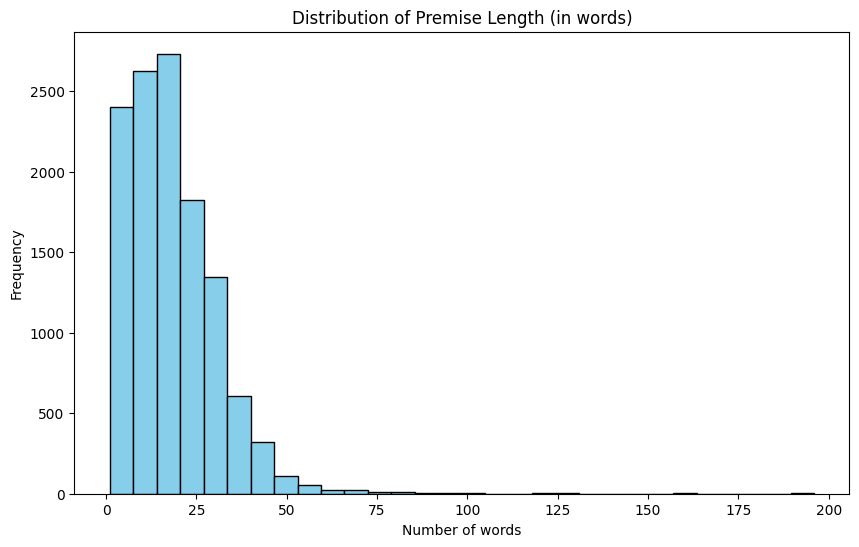

In [3]:

# Plot the distribution of premise lengths
plt.figure(figsize=(10,6))
plt.hist(premise_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Premise Length (in words)")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()


The relatively low average word counts in our dataset indicate that using the standard 512-token limit is excessive. To conserve computational resources and reduce processing time, we have set the maximum token length to 128 tokens (defined in next cell).

#### Cell 3: Defining Helper Functions

In [4]:
from transformers import AutoTokenizer, TFAutoModel
from tensorflow import keras
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

def tokenize_data(model_name, dataframe, max_len=128):
    """
    Loads a tokenizer for a given model and converts premise/hypothesis text to numerical IDs using the specified Hugging Face model.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    encodings = tokenizer(
        list(dataframe['premise'].values),
        list(dataframe['hypothesis'].values),
        truncation=True,
        padding='max_length',
        max_length=max_len,
        return_tensors='tf'
    )
    return encodings

def build_model(model_name, max_len=128, num_labels=3, lr=2e-5, dropout_rate=0.3):
    """
    Create a Keras model using TFAutoModel + a simple classification head.
    """
    base_model = TFAutoModel.from_pretrained(model_name)
    input_ids      = keras.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = keras.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    outputs = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    cls_token = outputs.last_hidden_state[:, 0, :]  # [CLS]

    x = keras.layers.Dropout(dropout_rate)(cls_token)
    x = keras.layers.Dense(num_labels, activation='softmax')(x)

    model = keras.Model(inputs=[input_ids, attention_mask], outputs=x)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def plot_history(history, title_prefix=""):
    """
    Plots training and validation accuracy/loss
    """
    hist = history.history
    epochs = range(1, len(hist['loss']) + 1)

    plt.figure(figsize=(10,4))
    # Plot Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, hist['loss'], 'bo-', label='Train Loss')
    if 'val_loss' in hist:
        plt.plot(epochs, hist['val_loss'], 'ro-', label='Val Loss')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Sub-Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, hist['accuracy'], 'bo-', label='Train Acc')
    if 'val_accuracy' in hist:
        plt.plot(epochs, hist['val_accuracy'], 'ro-', label='Val Acc')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Sub-Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

print("Helper functions defined.")

Helper functions defined.


#### Cell 4: Preparing Train/Validation Split

In [5]:
"""
Shuffle the training data and split off 10% as a validation set to monitor performance.
"""

VALIDATION_SPLIT = 0.1
val_size = int(len(train_data) * VALIDATION_SPLIT)

train_data_shuffled = train_data.sample(frac=1, random_state=SEED).reset_index(drop=True)

val_data = train_data_shuffled.iloc[:val_size]
train_data_ = train_data_shuffled.iloc[val_size:]

y_val = val_data['label'].values
y_train = train_data_['label'].values

print(f"Training set size: {len(train_data_)}")
print(f"Validation set size: {len(val_data)}")

Training set size: 10908
Validation set size: 1212


#### Cell 5: Training Multiple Models
We define a list of model candidates:
1. **XLM-RoBERTa**
2. **mbart-large-cc25**
3. **Multilingual BERT**
4. **mDeBERTa**

For each:
1. We **tokenize** train and validation data.
2. **Build** the Keras model.
3. **Train** for a specified number of epochs, using cross-entropy.
4. **Evaluate** on the validation set.
5. **Predict** on test data.
6. **Save** each model’s predictions to a CSV.

In [ ]:
model_candidates = [
    # "joeddav/xlm-roberta-large-xnli",
    "facebook/mbart-large-cc25",
    # "bert-base-multilingual-cased",
    # "microsoft/mdeberta-v3-base"
]

# Training Parameters
BATCH_SIZE = 8   # Adjust to fit GPU memory
EPOCHS = 1     # Full epochs (will be split into sub-epochs)
MAX_LEN = 128     # Increase if memory allows

# Organize Results Data
results = {}                  # model_name -> validation accuracy
predictions_dict = {}         # model_name -> predicted labels on test
predictions_csv_dict = {}     # model_name -> CSV path for predictions
saved_model_paths = []        # track where each model is saved

# Model Training
for model_name in model_candidates:
    print(f"\n=== Training model: {model_name} ===")
    # Tokenize train & val
    train_encodings = tokenize_data(model_name, train_data_, max_len=MAX_LEN)
    val_encodings   = tokenize_data(model_name, val_data,   max_len=MAX_LEN)

    # Build TF Datasets
    train_dataset = (
        tf.data.Dataset
        .from_tensor_slices((dict(train_encodings), y_train))
        .shuffle(buffer_size=len(train_data_))
        .batch(BATCH_SIZE)
    )

    val_dataset = (
        tf.data.Dataset
        .from_tensor_slices((dict(val_encodings), y_val))
        .batch(BATCH_SIZE)
    )

    # Calculate original steps and then split epochs into sub-epochs
    original_steps = len(list(train_dataset))
    subepochs_per_epoch = 10
    steps_per_subepoch = original_steps // subepochs_per_epoch
    total_subepochs = EPOCHS * subepochs_per_epoch  # ex) 3 * 10 = 30

    print(f"Original steps per epoch: {original_steps}")
    print(f"Sub-epochs per epoch: {subepochs_per_epoch}")
    print(f"Steps per sub-epoch: {steps_per_subepoch}")
    print(f"Total sub-epochs: {total_subepochs}")

    # Build model
    model = build_model(model_name, max_len=MAX_LEN)

    # Train: Use total_subepochs as the number of epochs and steps_per_subepoch as steps per epoch.
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=total_subepochs,
        steps_per_epoch=steps_per_subepoch,
        verbose=1
    )

    # Plot training history (30 slices)
    plot_history(history, title_prefix=model_name)

    # Evaluate on validation set
    val_loss, val_acc = model.evaluate(val_dataset, verbose=0)
    results[model_name] = val_acc
    print(f"Validation Accuracy for {model_name}: {val_acc:.4f}")

    # Predict on the test set
    test_encodings = tokenize_data(model_name, test_data, max_len=MAX_LEN)
    test_dataset = tf.data.Dataset.from_tensor_slices(dict(test_encodings)).batch(BATCH_SIZE)
    test_preds = model.predict(test_dataset)
    test_labels = np.argmax(test_preds, axis=1)
    predictions_dict[model_name] = test_labels

    # Save model
    save_path = f"./{model_name.replace('/', '_')}_model"
    model.save(save_path)
    saved_model_paths.append(save_path)
    print(f"Model saved to {save_path}")

    # Create and save CSV for predictions
    pred_csv_path = f"{model_name.replace('/', '_')}_predictions.csv"
    submission_df = pd.DataFrame({
        'id': test_data['id'],
        'prediction': test_labels
    })
    submission_df.to_csv(pred_csv_path, index=False)
    predictions_csv_dict[model_name] = pred_csv_path
    print(f"Prediction CSV saved as {pred_csv_path}\n")


=== Training model: facebook/mbart-large-cc25 ===


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Original steps per epoch: 1364
Sub-epochs per epoch: 10
Steps per sub-epoch: 136
Total sub-epochs: 10


tf_model.h5:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

Some layers from the model checkpoint at facebook/mbart-large-cc25 were not used when initializing TFMBartModel: ['final_logits_bias']
- This IS expected if you are initializing TFMBartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFMBartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFMBartModel were initialized from the model checkpoint at facebook/mbart-large-cc25.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMBartModel for predictions without further training.


Epoch 1/10


#### Cell 6: Comparing & Saving Predictions
Here we:
1. Summarize each model’s validation accuracy.
2. Pick the **best** model.
3. Copy that model’s prediction CSV to **`submission.csv`** for Kaggle.


In [ ]:
# Create summary DataFrame
model_performance_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Val Accuracy': list(results.values()),
    'Prediction CSV': [predictions_csv_dict[m] for m in results.keys()]
}).sort_values(by='Val Accuracy', ascending=False)

print("=== Model Validation Performance ===")
display(model_performance_df)

# Select best model
best_model_name = model_performance_df.iloc[0]['Model']
best_model_csv = model_performance_df.iloc[0]['Prediction CSV']

# Copy best model's CSV to submission.csv
shutil.copyfile(best_model_csv, "submission.csv")

print(f"\nBest Model: {best_model_name}")

#### Cell 7: Compare Early Predictions
We can look at the first 10 predictions from each model side by side to see if they disagree on specific samples.


In [ ]:
comparison_df = pd.DataFrame()
comparison_df['test_id'] = test_data['id'].head(10)

for model_name in model_candidates:
    comparison_df[model_name] = predictions_dict[model_name][:10]

comparison_df

## 5. Conclusion

In this work, we demonstrated a **multilingual classification** approach using state-of-the-art pretrained transformers, including:

- **XLM-RoBERTa**
- **Multilingual BERT**
- **mDeBERTa**
- **mBART**

Each model was fine-tuned on the **Contradictory, My Dear Watson** dataset for 2 epochs. Although longer training typically improves performance, our experiments showed that even with limited epochs, the models achieved competitive results. Notably, **XLM-RoBERTa** emerged as the best performer. Interestingly, we observed that training XLM-RoBERTa for just 1 epoch resulted in a validation score of 0.89, compared to 0.84 for 2 epochs under the same conditions—likely due to inherent variability in the training process. This suggests that additional training might yield only marginal improvements relative to the extra computational cost.

### Potential Improvements
- **Longer Training**: Exploring more epochs may help, provided that the validation performance eventually plateaus.
- **Hyperparameter Tuning**: Fine-tuning the learning rate, batch size, and other parameters could yield further gains.
- **Data Augmentation**: Incorporating more diverse or augmented training data could help improve robustness.

Overall, the results indicate that pretrained multilingual transformers, particularly XLM-RoBERTa, are highly effective for this complex textual entailment task.

## 6. References

- **Vaswani et al., 2017**  
  *Attention Is All You Need.*  
  In *Advances in Neural Information Processing Systems (NIPS)*.  
  [https://arxiv.org/abs/1706.03762](https://arxiv.org/abs/1706.03762)

- **Devlin et al., 2019**  
  *BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding.*  
  In *North American Chapter of the Association for Computational Linguistics (NAACL)*.  
  [https://arxiv.org/abs/1810.04805](https://arxiv.org/abs/1810.04805)

- **Conneau et al., 2020**  
  *Unsupervised Cross-lingual Representation Learning at Scale.*  
  In *Annual Meeting of the Association for Computational Linguistics (ACL)*.  
  (XLM-RoBERTa)  
  [https://arxiv.org/abs/1911.02116](https://arxiv.org/abs/1911.02116)

- **He et al., 2021**  
  *DeBERTa: Decoding-Enhanced BERT with Disentangled Attention.*  
  In *International Conference on Learning Representations (ICLR)*.  
  [https://arxiv.org/abs/2006.03654](https://arxiv.org/abs/2006.03654)

- **Liu et al., 2020**  
  *mBART: Multilingual Denoising Pre-training for Neural Machine Translation.*  
  arXiv preprint arXiv:2001.08210.  
  [https://arxiv.org/abs/2001.08210](https://arxiv.org/abs/2001.08210)

- **Hugging Face Transformers**  
  [https://huggingface.co/docs/transformers](https://huggingface.co/docs/transformers)